# Analysis of brainstorming transcript : Data from Leximancer
The following is an ongoing analysis of transcripts from 18 teams; 9 of the teams performed what is called "free" brainstorming
The remaining 9 performed an alternating divergent-convergent process. The transcript for each team is split into its divergent and convergent components. 
We use occurrences calculated from Leximancer to perform this computation.

## Code credits
A lot of this code is inspired from, and in several cases reused directly from the code written by Moses Boudourides, Sergios Lenis & Pantelis Vikatos. Their version can be seen at:
http://mboudour.github.io/2016/03/22/Clinton-Sanders-Word-Nets.html

We change some aspects of the commonality functions and co-occurrence functions to suit our requirements, see code comments that accompany these functions below for details.

In [1]:
# Get all imports out of the way
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet_ic
from nltk.corpus import stopwords
from nltk.corpus.reader.wordnet import information_content
from nltk.tokenize import sent_tokenize
import itertools
import codecs
import re
import pprint as pp
import operator
from collections import OrderedDict
from collections import Counter
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

## Step 1: Read Files
We first read the transcript text files. The goal is to understand what 
concepts are common between the two groups (Free and D-C), and what concepts are unique to each group.

In [2]:
# Locations of input files. These files have been anonymized, and the files themselves will not be available
# in this folder, to preserve the privacy of the teams.
textPathFree = "../../../private/brainstorming_viz_data/free_group/"
textPathDC = "../../../private/brainstorming_viz_data/d-c_group/"

# Teamwise transcript (of divergent processes) of the "Free Brainstorming" group
fileNamesFree = [
    "teamA_part1_divergent.txt",
    "teamA_part2_convergent.txt",
    "teamB_part1_divergent.txt",
    "teamB_part2_convergent.txt",
    "teamC_part1_divergent.txt",
    "teamC_part2_convergent.txt",
    "teamD_part1_divergent.txt",
    "teamD_part2_convergent.txt",
    "teamE_part1_divergent.txt",
    "teamE_part2_convergent.txt",
    "teamF_part1_divergent.txt",
    "teamF_part2_convergent.txt",
    "teamG_part1_divergent.txt",
    "teamG_part2_convergent.txt",
    "teamH_part1_divergent.txt",
    "teamH_part2_convergent.txt",
    "teamI_part1_divergent.txt",
    "teamI_part2_convergent.txt"]

# Teamwise transcript (of divergent processes) of the "Divergent-Convergent (D-C) Brainstorming" group
fileNamesDC = [
    "teamJ_part1_divergent.txt",
    "teamJ_part2_convergent.txt",
    "teamJ_part3_divergent.txt",
    "teamJ_part4_convergent.txt",
    "teamK_part1_divergent.txt",
    "teamK_part2_convergent.txt",
    "teamK_part3_divergent.txt",
    "teamK_part4_convergent.txt",
    "teamL_part1_divergent.txt",
    "teamL_part2_convergent.txt",
    "teamL_part3_divergent.txt",
    "teamL_part4_convergent.txt",
    "teamM_part1_divergent.txt",
    "teamM_part2_3_convergent_divergent.txt",
    "teamM_part2_convergent.txt",
    "teamM_part4_convergent.txt",
    "teamN_part1_divergent.txt",
    "teamN_part2_convergent.txt",
    "teamN_part3_divergent.txt",
    "teamN_part4_convergent.txt",
    "teamO_part1_divergent.txt",
    "teamO_part2_3_conv_div.txt",
    "teamO_part4_convergent.txt",
    "teamP_part1_divergent.txt",
    "teamP_part2_convergent.txt",
    "teamP_part3_divergent.txt",
    "teamP_part4_convergent.txt",
    "teamQ_part1_divergent.txt",
    "teamQ_part2_convergent.txt",
    "teamQ_part3_4_div_conv.txt",
    "teamR_part1_divergent.txt",
    "teamR_part2_convergent.txt",
    "teamR_part3_divergent.txt",
    "teamR_part4_convergent.txt"]

def openFiles(fileNamesList, filePath):
    # Given a list of file names and a path for the files, returns a
    # list of file objects
    fObjList = []
    for fileName in fileNamesList:
        fObj = open(filePath + fileName, 'r', encoding='utf8')
        fObjList.append(fObj)
    return fObjList

filesListFree = openFiles(fileNamesFree, textPathFree)
filesListDC = openFiles(fileNamesDC, textPathDC)

## Step 2: File processing
To avoid processing errors, we first remove all non-UTF characters in the text (such as distinct opening and closing quotes)
and replace them with corresponding UTF characters.
These transcripts also come with the transcriber's observations, such as [laughter], or [silent]. We remove all such observations so that we are only looking at team members' speech.

In [3]:
# Some of these files have non-UTF characters that may need to be removed.
def removeSpecials(filesList):
    # Remove some incompatible unicode characters such as distinct
    # opening and closing quotes, ellipsis etc.
    # Also finally converts all text to lowercase
    outString = ''
    for inFile in filesList:
        # print("reading file",inFile.name.split("/")[-1], "...", end="")
        temp = inFile.read()
        subsFileQuotes = re.sub(u"(\u2018|\u2019)", "'", temp)
        subsFileDQuotes = re.sub(u'(\u201c|\u201d)', '"', subsFileQuotes)
        subsFileEllipsis = re.sub(u"\u2026", "...", subsFileDQuotes)
        outString += subsFileEllipsis
        # print("done.")
    return outString.lower()

group1_convergent_raw = removeSpecials(filesListFree)
group2_convergent_raw = removeSpecials(filesListDC)

In [4]:
# These files have the transcriber's observations like [laughter], [silent], [cross-talk] etc.
# These may throw off the text analysis, so we remove them. These are typically within parantheses,
# so we can remove everything between these parantheses.

def removeObservations(test_str) :
    # removes all text within parantheses
    # these are usually observations by the transcriber
    # and thus should not be considered in content analysis
    # code from http://stackoverflow.com/questions/14596884/remove-text-between-and-in-python
    ret = ''
    skip1c = 0
    skip2c = 0
    squareparen = 0
    for i in test_str:
        if i == '[':
            skip1c += 1
            squareparen += 1
        elif i == '(':
            skip2c += 1
        elif i == ']' and skip1c > 0:
            skip1c -= 1
        elif i == ')'and skip2c > 0:
            skip2c -= 1
        elif skip1c == 0 and skip2c == 0:
            ret += i
    print("Number of observations removed", str(squareparen))
    return ret

group1 = removeObservations(group1_convergent_raw)
group2 = removeObservations(group2_convergent_raw)

Number of observations removed 1709
Number of observations removed 1128


## Step 3: Tokenizing and stop word removal (to be used later for word count)
We split the text from the transcripts into individual words. Of these, we remove "stop words" -- common words that add little meaning, such as articles, pronouns, prepositions etc. 
An added step would be to then "lemmatize" the resulting words so that words such as "short", "shorter", and "shortest" are treated the same (short), and words with different tenses, singular/plural forms etc. are also treated the same. However, we will do this at a later stage so that we can first identify all occurrences of the filtered words in the original text. To do this, we will need to implement whole-word matches, which will not be accurate if we were to lemmatize first.

In [7]:
# Split the file into words using a tokenizer
# Also name the variables a little more meaningfully

freeWords = nltk.word_tokenize(group1) 
DCWords = nltk.word_tokenize(group2)

# Remove stop words
freeWordsFiltered = [w for w in freeWords if not w in stopwords.words('english')]
DCWordsFiltered = [w for w in DCWords if not w in stopwords.words('english')]
freeDiff = len(freeWords) - len(freeWordsFiltered)
DCDiff = len(DCWords) - len(DCWordsFiltered)
# print(freeDiff, "stop words removed from a total of", len(freeWords),"in the Free group")
# print(DCDiff, "stop words removed from a total of", len(DCWords), "in the convergent-Convergent group")

## Step 3.1: Remove irrelevant words (not needed for now)##
This step is to be performed only after generating a co-occurrence network first. Exploring the interactive network shown at Step 7 below allows us to identify words that add more noise than information to the graph. This is, of course, subjectively determined. These words are removed from consideration in the procedure below.

In [8]:
# Noun phrases that can be removed:
# to_be_removed = ['yea', 'up', 'down'] 
# 
# keys_to_delete = []
# for key in topCommon.keys():
#     if key in to_be_removed:
#         keys_to_delete.append(key)
# for key in keys_to_delete:
#     del topCommon[key] # could not have deleted item from iterable 
#                     # from within the loop
# topCommonFiltered=topCommon.keys()
# print("Number of common words in the top third after filtering:", len(topCommonFiltered))

## Step 4: Identify co-occurrences
We go over each sentence in the original dataset and look for word co-occurrences; pairs of words that occur in the same sentence. This helps us draw a concept map for each group's divergent brainstorming transcript data.

In [10]:
# Function to count co-occurrences of common noun phrases in sentences
# NOTE: We're not using the function "occurrences" as found in the reference code anymore 
# as it returns partial matches, i.e. if it has to look for the word "rig" it returns sentences
# that have the word "right" but not "rig", creating a false count.
# it also seems to consider the co-occurrences of word A and word B separately if A occurs before B
# from when B occurs before A. We rectify these issues below.

# Use the function altOccurrences below instead.
# That function will in turn call the below regexp to find whole words.
def findWholeWord(w):
    # regular expression to find whole words
    return re.compile(r'\b({0})\b'.format(w), flags=re.IGNORECASE).search

def findOccurs(sentences, terms):
    # First find occurrences of every term in every sentence
    termOcc = []
    for ind, term in enumerate(terms):
        # search for term in all sentences.
        termData = [term, []]
        for sent in sentences:
            match = findWholeWord(term)(sent)
            if match :
                    termData[1].append(sent)
        if len(termData[1]) > 0:
            termOcc.append(termData)
    # Each entry in termOcc is now of the kind [term, [sent1,
    # sent2,...]]
    # Now, to iterate through the termOcc list to find co-occurrences
    print("Term occurrences computed. Finding term co-occurrences...")
    occurdict = {}
    contextdict = {}
    for ind, termData in enumerate(termOcc):
        # search only through the REST of the list (to prevent repeat
        # counts)
        for cotermData in termOcc[ind+1:]:
            # NOTE : termData and coTermData are of type [term, [s1,
            # s2,...]]
            for sent in termData[1]:
                match = findWholeWord(cotermData[0])(sent)
                if match :
                    wordkey = termData[0]+" - "+cotermData[0]
                    if wordkey in contextdict:
                        contextdict[wordkey] = contextdict[wordkey] +\
                        [sent]
                    else :
                        contextdict[wordkey] = [sent]
                    if wordkey in occurdict:
                        occurdict[wordkey] = occurdict[wordkey] + 1
                    else :
                        occurdict[wordkey] = 1
    return (occurdict, contextdict)


def group_sentences(sentString, numTokens):
    sentenceArray = sent_tokenize(sentString)
    outputArray = []
    currentSentences = []
    for index, sentence in enumerate(sentenceArray):
        currentSentences.append(sentence)
        if len(currentSentences) == numTokens:
            combined = ''.join(s for s in currentSentences)
            outputArray.append(combined)
            currentSentences = []
    return outputArray

# Call function to find convergent and convergent terms
# freeCooccur_top, freeContext_top = altOccurrences(group1_convergent, topCommon)
# print("Number of unique co-occurrences found in the Free Group:", len(freeCooccur_top))


words_from_leximancer = ["spring", "gun", "top", "comes", "time", "toy",
        "probably", "hit", "goes", "looks", "motion", "sure", "shoot",
        "idea", "stuff", "water", "control", "different", "kids",
        "draw", "wheels", "things", "use", "thinking", "ball", "work",
        "play", "game", "cool", "car", "guy", "people", "cool",
        "that’d", "take", "guess", "game", "play", "work", "ball",
        "thinking", "use", "things", "wheels", "draw", "ones", "kids",
        "different", "control", "water", "stuff", "idea", "shoot",
        "motion", "looks", "goes", "probably", "toy", "time"]

freeGrpWordsFinal = words_from_leximancer
# Find occurrences of these words in the text.
# First, the free group:
# g1sentences = sent_tokenize(group1)
g1sentences = group_sentences(group1, 2)
# print(g1sentences)
freeCooccur, freeContext = findOccurs(g1sentences, freeGrpWordsFinal)
print("Number of unique co-occurrences found in the Free Group:",
        len(freeCooccur))


Term occurrences computed. Finding term co-occurrences...
Number of unique co-occurrences found in the Free Group: 718


## Step 5: Plot word co-occurrence for the Free Brainstorming group
We use the data obtained in step 6 to plot a graph of co-occurrences in the "free brainstorming" group.

In [11]:
# Function to construct a graph of common noun phrases tied by 
# their co-occurrences in sentences of a transcript
def makegraph(occurrences):
    G = nx.Graph()
    weights = []
    for edgs,wt in occurrences.items():
        edg = edgs.split(' - ')
        G.add_edge(edg[0], edg[1], weight=wt)
        G.add_node(edg[0], label=edg[0])
        G.add_node(edg[1], label=edg[1])
        weights.append(wt)
    return [G, weights]

freeGraphData = makegraph(freeCooccur)
GFree = freeGraphData[0]
freeEdges = freeGraphData[1]
posFree = nx.spring_layout(GFree, iterations=20)

In [12]:
from networkx.drawing.nx_agraph import graphviz_layout
from bokeh import mpl
from bokeh.plotting import output_notebook, show, figure
from bokeh.models import HoverTool, ColumnDataSource
output_notebook()

# First, create a graph layout
pos = nx.spring_layout(GFree, iterations=20)

def draw_interactive_network(graphObj, positions, wordFreq, wordCooccurs, wordContext, graphTitle):
    # Redrawing the graph from scratch so that the network may be interactive
    # NOTE: The current interactions are:
    # Hover on a node to show corresponding word's occurrences in the text
    # Hover on an edge center to show:
    #    * Number of co-occurrences that the edge indicates
    #    * The context, i.e., sentences in which the words co-occur.
    
    # Then obtain locations and metadata of the nodes from this layout
    xlocs = []
    ylocs = []
    nodeLabels = []
    nodeFreq = []
    nodeSizes = []
    for i in positions:
        nodeLabels.append(i)
        nodeFreq.append(str(wordFreq[i])+" occurrence(s)")
        nodeSizes.append(wordFreq[i]+10)
        xlocs.append(positions[i][0])
        ylocs.append(positions[i][1])

    # The eventual goal ofcontextHTML is to convert contextdict values 
    # from lists to html list items.
    # However, bokeh.js currently does not handle html tags *inside* variables.
    # Curently using the slightly ugly "||||" separator below
    contextHTML = {}
    for i in wordContext:
        conList = wordContext[i]
        conHTML = ""
        for item in conList:
            conHTML = conHTML + " " + item+" ||||"
        contextHTML[i] = conHTML.rstrip("|")

    # obtain locations and metadata of the edges from the layout
    edgeXpairs = []
    edgeYpairs = []
    edgeLabels = []
    edgeMidPtX = []
    edgeMidPtY = []
    edgeFreq = []
    edgeW = []
    edgeContext = []
    edgeListNames = wordCooccurs.keys()
    for i in graphObj.edges():
        w1 = i[0]
        w2 = i[1]
        w1x, w1y = positions[w1]
        w2x, w2y = positions[w2]
        edgeXpairs.append([w1x, w2x])
        edgeYpairs.append([w1y, w2y])
        edgeLabels.append(w1+" & "+w2)
        edgeMidPtX.append((w1x + w2x)/2)
        edgeMidPtY.append((w1y + w2y)/2)
        edgeString = w1 + ' - ' + w2
        edgeStringRev = w2 + ' - '+ w1
        if (edgeString in edgeListNames):
            edgeFreq.append(str(wordCooccurs[edgeString])+" co-occurrence(s)")
            edgeW.append(wordCooccurs[edgeString])
            edgeConString = contextHTML[edgeString]
            edgeContext.append(edgeConString)
        else :
            edgeFreq.append(str(wordCooccurs[edgeStringRev])+" co-occurrence(s)")
            edgeW.append(wordCooccurs[edgeStringRev])
            edgeConString = contextHTML[edgeStringRev]
            edgeContext.append(edgeConString)


    # Create a ColumnDataSource for the hover tool to reference
    dataPoints = dict(x = (xlocs + edgeMidPtX),
                      y = (ylocs + edgeMidPtY),
                      occ = (nodeFreq + edgeFreq),
                      desc = (nodeLabels + edgeLabels),
                      vis = ([1.0 for x in nodeLabels] + [0.0 for x in edgeLabels]),
                      size = (nodeSizes + [15 for x in edgeLabels]),
                      cxt = (["" for x in nodeLabels] + edgeContext))

    interact = ColumnDataSource(data = dataPoints)

    hover_data = HoverTool(tooltips ="""
                                   <text style="font-size: 17px; font-weight: bold;">@desc</text>
                                   <br>
                                   <text style="font-size: 15px">@occ</text>
                                   <div style="width:300px;font-size: 11px; font-face='Courier'">
                                       @cxt
                                   </div>
                                   """,
                                   point_policy='snap_to_data')

    p = figure(title = graphTitle, width=900, height=900)
    p.multi_line(edgeXpairs, edgeYpairs, color='gray', alpha=0.4, line_width=edgeW)
    p.circle('x', 'y', size='size', fill_color='#fed9a6', line_color="gray", alpha='vis', source=interact)
    p.text(xlocs, ylocs, nodeLabels, text_font="Roboto", text_color='#333333', text_font_size='11pt', 
           text_align='center', text_baseline='middle' )

    p.add_tools(hover_data)
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.axis.visible = None
    show(p)

freeGrpWordCount = Counter(freeWordsFiltered)
freeGrpFrequencies = {}
for word in freeGrpWordsFinal:
    freeGrpFrequencies[word] = freeGrpWordCount[word]

draw_interactive_network(GFree, pos, freeGrpFrequencies, freeCooccur, freeContext, 
                         "Co-occurrences in the Free Brainstorming Group")

Loading BokehJS ...

#### NOTE: ####
Move your mouse pointer over the **_nodes_** in the graph above to see the number of occurrences of the corresponding word in the transcript. You can also mouseover the **_mid-point of an edge_** to see both the number of co-occurrences of the two words it joins, and the context in which they co-occur.

## Step 6: Calculate centralities ##
The centralities of common words above can be calculated. Here, we look at the following centralities: NOTE: Most definitions here are from Wikipedia, but need to refine these to the definitions presented in corresponding papers.
### Betweenness Centrality ###
Defined for a node, this is equal to the number of shortest paths from all vertices to all others that pass through that node.
### Closeness Centrality ###
This is defined as the reciprocal of the sum of its distances from all other nodes.
### Degree Centality ###
This is defined as the number of links incident upon a node.
### Katz Centrality ###
Similar to Degree centrality, the Katz centrality measures the number of all nodes that can be connected through a path, while penalizing the contributions of distant nodes.
### Eigenvector Centrality ###
This is a measure of the influence of a node in a network. It assigns relative scores to all nodes in the network based on the concept that connections to high-scoring nodes contribute more to the score of the node in question than equal connections to low-scoring nodes.
### PageRank ###
Similar to Katz centrality, the pagerank measure has an additional weighting measure that weights edges on their "influence" on the network (insert equation later).

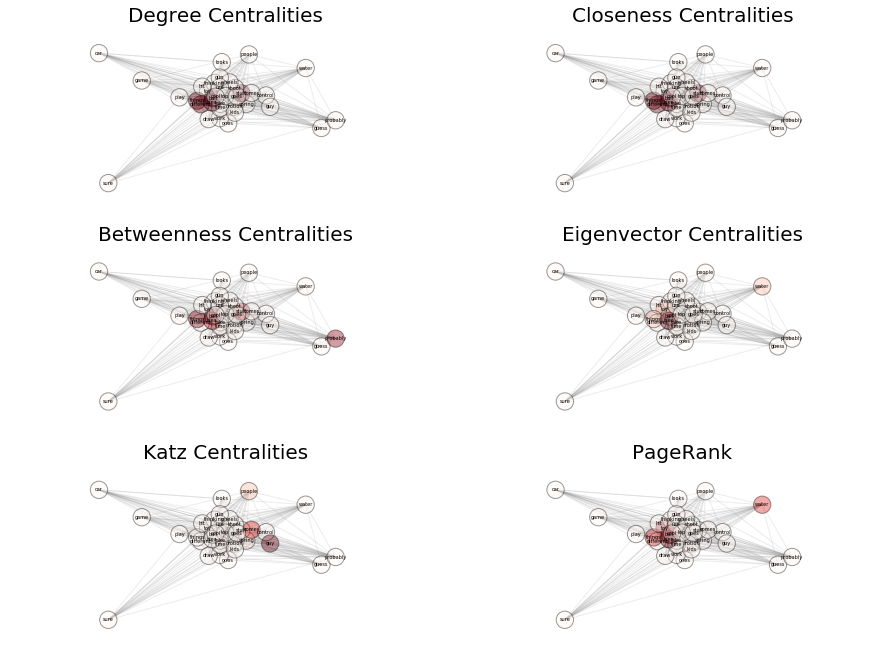

In [13]:
%matplotlib inline
from tools import draw_centralities_subplots
centrali=draw_centralities_subplots(GFree, pos, withLabels=True,labfs=5, figsi=(15, 15), ealpha=0.15, vals=True)

## 6.1 Generate Table of Centralities (Words common to both Groups)
We list the centralities of the words common to both groups, calculated using the above metrics. 

In [14]:
# Generate Centralities Table
pd.options.display.max_rows = 999
dfchc=pd.DataFrame()
dfchc.insert(0,'Common Nouns', centrali[list(centrali.keys())[0]].keys())
u=1
for i,k in centrali.items():
    dfchc.insert(u,i,k.values())
dfchc

,Common Nouns,degree_centrality,katz_centrality,betweenness_centrality,page_rank,closeness_centrality,eigenvector_centrality
0,cool,0.794118,0.087282,0.011187,0.017676,0.829268,0.158195
1,ones,0.500000,0.003906,0.003146,0.011233,0.666667,0.014859
2,toy,0.823529,0.003483,0.011439,0.053300,0.809524,0.360863
3,play,0.852941,-0.025366,0.013469,0.037996,0.829268,0.100233
4,different,0.941176,0.006839,0.014755,0.038904,0.894737,0.107514
5,stuff,0.941176,-0.000866,0.017464,0.035486,0.894737,0.116955
6,motion,0.676471,0.014532,0.005915,0.029272,0.723404,0.129063
7,sure,0.588235,0.046541,0.005121,0.015227,0.708333,0.049999
8,control,0.617647,0.008487,0.004853,0.022820,0.693878,0.038453
9,thinking,0.911765,-0.016670,0.015383,0.030503,0.871795,0.084121


## Step 7: Identify Communities ##
Here communities are nothing but partitions that can be made to the network. The community identification is performed using the [Louvain method](http://arxiv.org/pdf/0803.0476.pdf). Python has an [implementation of the algorithm](http://perso.crans.org/aynaud/communities/) as part of the NetworkX library.

For details refer "tools.py" in the parent directory. Identifying these partitions can help us identify "themes" to each group's transcripts, helping us understand the group's behavior better.

Number of communities of  Co-occurrences in the Free Brainstorming Group  =  14
Community partition of  Co-occurrences in the Free Brainstorming Group :
[['looks', 'cool'],
 ['ones', 'take', 'different', 'guess'],
 ['toy'],
 ['motion'],
 ['stuff'],
 ['play', 'car', 'things', 'people'],
 ['sure', 'work'],
 ['control', 'hit', 'spring', 'comes', 'ball', 'goes'],
 ['thinking', 'game'],
 ['shoot', 'gun', 'water', 'top'],
 ['draw', 'wheels'],
 ['guy', 'time', 'use'],
 ['idea'],
 ['probably', 'kids']]
Community modularity of Co-occurrences in the Free Brainstorming Group  =  0.5348438781895507


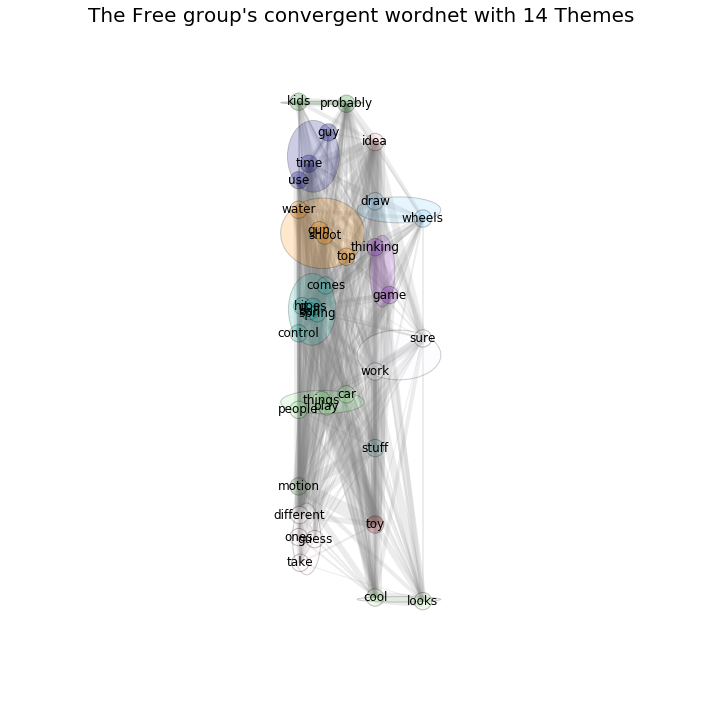

In [15]:
# detecting communities of common phrases
%reload_ext autoreload
%autoreload 2
from tools import draw_comms, modul_arity, print_communities
sstt = "Co-occurrences in the Free Brainstorming Group"
part, nodper = print_communities(GFree, sstt)

d=0.8 
dd=0.8
c=1.2
cc=1.4
alpha=0.2
ealpha=0.15
vcc={}

sstta="The Free group's convergent wordnet with "+ str(max(part.values())+1) + " Themes" 
draw_comms(GFree,GFree.nodes(),[],[],[] ,part,part,d,dd,c,cc,alpha,ealpha,nodper,sstta,titlefont=20,labelfont=12,valpha=0.25)

## Step 8: Perform steps 5-7 for the Divergent-Convergent Group ##

In [16]:
# Identify co-occurrences of the common words in the D-C transcript dataset
g2sentences = sent_tokenize(group2)
DCCooccur, DCContext = findOccurs(g2sentences, words_from_leximancer)
print("Number of unique co-occurrences found in the DC Group:", len(DCCooccur))

Term occurrences computed. Finding term co-occurrences...
Number of unique co-occurrences found in the DC Group: 529


In [17]:
DCGraphData = makegraph(DCCooccur)
GDC = DCGraphData[0]
DCEdges = DCGraphData[1]
pos1 = nx.spring_layout(GDC, iterations=20)

In [18]:
DCGrpWordCount = Counter(DCWordsFiltered)
DCGrpFrequencies = {}
for word in words_from_leximancer:
    DCGrpFrequencies[word] = DCGrpWordCount[word]

draw_interactive_network(GDC, pos1, DCGrpFrequencies, DCCooccur, DCContext, 
                         "Co-occurrences in the D-C Brainstorming Group")

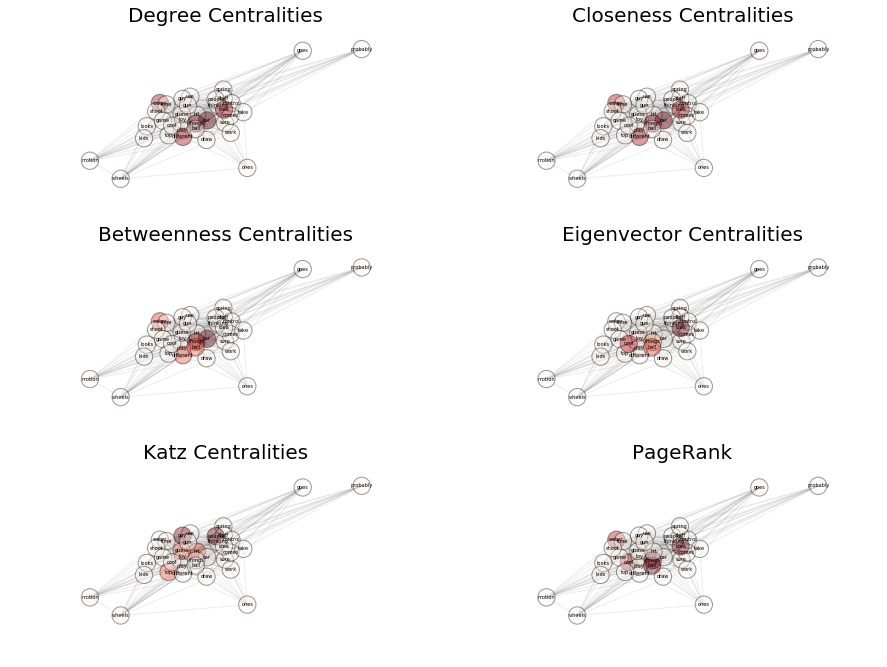

In [19]:
from tools import draw_centralities_subplots
centrali2=draw_centralities_subplots(GDC, pos1, withLabels=True,labfs=5, figsi=(15, 15), ealpha=0.15, vals=True)

## 8.1 Generate Table of Centralities of common words using occurrences in the D-C Group
We list the centralities of the words unique to the D-C Group calculated using the above metrics. 

In [20]:
# Generate Centralities Table
pd.options.display.max_rows = 999
dfchc2=pd.DataFrame()
dfchc2.insert(0,'Common Nouns', centrali2[list(centrali.keys())[1]].keys())
u=1
for i,k in centrali2.items():
    if k != None:
        dfchc2.insert(u,i,k.values())
dfchc2

,Common Nouns,degree_centrality,katz_centrality,betweenness_centrality,page_rank,closeness_centrality,eigenvector_centrality
0,spring,0.264706,-0.244964,0.004191,0.049857,0.576271,0.016229
1,ones,0.323529,-0.339170,0.005765,0.010304,0.596491,0.009913
2,toy,0.676471,-0.007152,0.021181,0.041438,0.723404,0.146058
3,play,0.558824,-0.029484,0.010346,0.031877,0.666667,0.069515
4,different,0.735294,0.006856,0.027597,0.040600,0.755556,0.101683
5,stuff,0.588235,-0.016130,0.011464,0.034054,0.680000,0.039000
6,motion,0.529412,0.002139,0.009507,0.033715,0.653846,0.080990
7,sure,0.352941,-0.471076,0.004047,0.010378,0.607143,0.030954
8,control,0.500000,0.014175,0.006998,0.026107,0.641509,0.051760
9,thinking,0.558824,0.022938,0.017909,0.036179,0.666667,0.117088


Number of communities of  Co-occurrences in the D-C Brainstorming Group  =  17
Community partition of  Co-occurrences in the D-C Brainstorming Group :
[['cool'],
 ['ones', 'work'],
 ['toy', 'motion'],
 ['different', 'things'],
 ['stuff', 'take'],
 ['play', 'kids'],
 ['sure', 'gun', 'water'],
 ['control'],
 ['thinking', 'game'],
 ['guy', 'time', 'shoot', 'hit', 'spring', 'guess', 'comes', 'people'],
 ['car', 'ball', 'wheels', 'top'],
 ['use'],
 ['draw'],
 ['idea'],
 ['looks'],
 ['probably'],
 ['goes']]
Community modularity of Co-occurrences in the D-C Brainstorming Group  =  0.6710828727434199


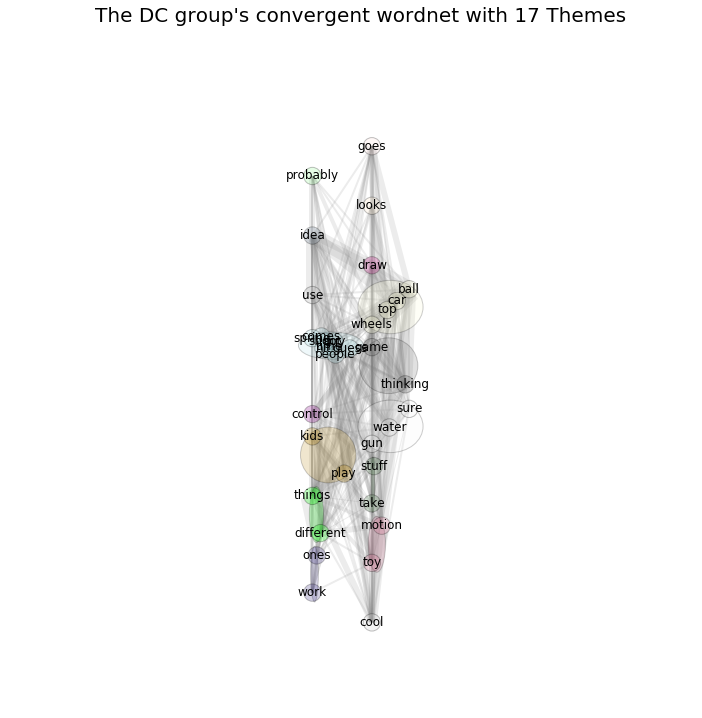

In [21]:
from tools import draw_comms, modul_arity, print_communities
sstt = "Co-occurrences in the D-C Brainstorming Group"
part, nodper = print_communities(GDC, sstt)

d=0.8 
dd=0.8
c=1.2
cc=1.4
alpha=0.2
ealpha=0.15
vcc={}

sstta="The DC group's convergent wordnet with "+ str(max(part.values())+1) + " Themes" 
draw_comms(GDC,GDC.nodes(),[],[],[] ,part,part,d,dd,c,cc,alpha,ealpha,nodper,sstta,titlefont=20,labelfont=12,valpha=0.25)